<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.955 · Models avançats de mineria de dades · PAC2</p>
<p style="margin: 0; text-align:right;">2017-2 · Màster universitari en Ciència de dades (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudis de Informàtica, Multimàdia i Telecomunicació</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PAC 2: Mètodes no supervisats

Al llarg d'aquesta pràctica veurem com aplicar diferents tècniques no supervisades
així com algunes de les seves aplicacions reals:

 1. **Clustering clàssio**: k-means i la regla del colze.
 - **Més enllá de k-means**: clustering jeràrquic.
 - **Reducció de dimensionalitat**: PCA i t-SNE.
 - **Aplicacions**:
     - Compressió d'imatges.
     - Segmentació d'imatges de satèl·lit.
   
Per a això necessitarem les següents llibreries:

In [64]:
import random

import numpy as np
import pandas as pd
from sklearn import cluster      # Algorismes de clustering.
from sklearn import datasets     # Crear datasets.

# Visualitzacio.
import matplotlib.pyplot as plt
import seaborn as sns

# Euclidean distance
from scipy.spatial.distance import cdist

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
#from sklearn import metrics

# Tractament d'imatges
from skimage import io, transform
from mypy_extensions import NoReturn
from mpl_toolkits.mplot3d import Axes3D

# Dendogrames
import scipy.cluster.hierarchy as hac
import sklearn.metrics as sm
from sklearn.cluster import AgglomerativeClustering

%matplotlib inline

## 1. Clustering clàssic: k-means i la regla del colze (2 punts)

Anem a generar un dataset compost per $n$ núvols de punts, on $n$ serà un nombre aleatori entre 2 i 4, usant el mòdul ```datasets``` de scikit-learn.

Hi ha 1500 punts en 2 dimensions (repartits en 4 clusters)


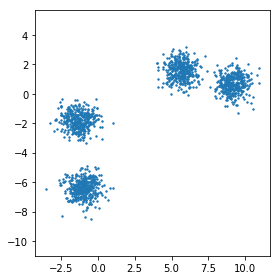

In [43]:
N_SAMPLES = 1500
MIN_CLUSTERS = 2
MAX_CLUSTERS = 4
# Generate isotropic Gaussian blobs for clustering. Parameters:
#   centers: a random integer between MIN_CLUSTERS and MAX_CLUSTERS
#   center_box: The bounding box for each cluster center
#   cluster_std: The standard deviation of the clusters
X, y = datasets.make_blobs(n_samples=N_SAMPLES, # Nombre de punts
                           n_features=2,        # Nombre de dimensions
                           centers=random.randint(MIN_CLUSTERS, MAX_CLUSTERS),      # Nombre de clusters
                           center_box=(-20, 20),
                           cluster_std=.6)
print('Hi ha {} punts en {} dimensions (repartits en {} clusters)'.format(X.shape[0], X.shape[1], y.max() + 1))
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(X[:,0], X[:,1], s=2)
#turns off the axis lines and labels
ax.axis('equal')
#Automatically adjust subplot parameters to give specified padding
plt.tight_layout()

Una tècnica per estimar $k$ és, com s'explica a la teoria:
> Els criteris anteriors (minimització de distàncies intra grup o maximització de distàncies inter grup) poden usar-se per establir un valor adequat per al paràmetre k. Valors k per als quals ja no s'aconsegueixen millores significatives en l'homogeneïtat interna dels segments o l'heterogeneïtat entre segments diferents, haurien de descartar-se.

El que popularment es coneix com *regla del colze*.

Primer cal calcular la suma dels errors quadràtics ([*SSE*](https://bl.ocks.org/rpgove/0060ff3b656618e9136b)) que consisteix en la suma de tots els errors (distància de cada punt al seu centroide assignat) al quadrat.

$$SSE = \sum_{i=1}^{K} \sum_{x \in C_i} euclidean(x, c_i)^2$$

On $K$ és el nombre de clusters a buscar per *k-means*, $x \in C_i$ són els punts que pertanyen al i-èsim cluster, $c_i$ és el centroide del cluster $C_i$ (al qual pertanty el punt $x$), i $euclidean$ és la [distància euclídea](https://en.wikipedia.org/wiki/Euclidean_distance).

Aquest procediment realitzat per a cada possible valor $k$, resulta en una funció monòtona decreixent, on l'eix $x$ representa els diferents valors de $k$, i l'eix $y$ el $SSE$. Intuïtivament es podrà observar un significatiu descens de l'error, que indicarà el valor idoni de $k$.

**Es demana realitzar la representació gràfica de la regla del colze al costat de la seva interpretació, utilitzant la llibreria ```matplotlib``` i la implementació en scikit-learn de [*k-means*](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).**

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> càlcul i visualització de la regla del colze.  
</div>

Distortion with k=1: 45247.40
Distortion with k=2: 7534.83
Distortion with k=3: 3580.64
Distortion with k=4: 1091.76
Distortion with k=5: 991.22
Distortion with k=6: 890.97
Distortion with k=7: 808.24
Distortion with k=8: 714.04
Distortion with k=9: 646.48
Distortion with k=10: 588.06


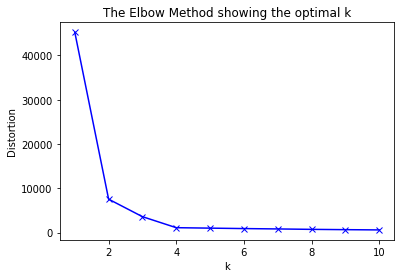

In [47]:
distortions = []
# Nombre de valors de K
K = range(1,11)
for k in K:
    kmeanModel = cluster.KMeans(n_clusters=k, random_state=0)
    kmeanModel.fit(X)
    # within-cluster SSE (distortion)
    distortions.append(kmeanModel.inertia_)
    print('Distortion with k={}: %.2f'.format(k) %kmeanModel.inertia_)

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()    

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi:</strong> Què s'interpreta en la gràfica? Com podria millorar-se l'elecció de $k$?  
</div>

Què s'interpreta en la gràfica?
ANP: Hem buscat quin valor de k seria l'idoni en aquest conjunt de dades. Hem determinat que el rang de k's a analitzar estigui entre 1 i 10 clusters.
Amb la regla del colze observem que a partir de k=4 la línia és molt plana. Per tant, aquest seria el valor òptim de k.
Això també ho verifiquem amb els valors mostrats de la distorsió (within-cluster SSE o error quadràtic dins del cluster). A partir de k=4 aquest valor decreix molt lentament, a diferència dels valors observats entre k=1 i k=4
Com podria millorar-se l'elecció de k?
ANP: El resultat de l'algorisme K-means depèn fortament dels centroides que es generen inicialment, els quals són seleccionats arbitràriament. I el fet d'haver d'establir un nombre per k abans d'aplicar l'algorisme tampoc és molt eficient.
Una millora possible seria la de millorar la generació dels centroides inicials.
Altres mètodes com alternativa al Elbow Method podrien ser l'Average silhouette Method i el Gap Statistic Method.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>[OPCIONAL] Implementació:</strong> algorisme <i>k-means</i> des de zero.  
</div>

En aquest cas, amb 2 dimensions, és molt senzill inferir el nombre de clústers visualitzant les dades. Però aquest mètode és de gran utilitat quan es compta amb dades d'alta dimensionalitat.

## 2. Més enllà de k-means: clustering jeràrquic (3 punts)

Però no tots els datasets són com els de l'exercici anterior. Per a aquesta segona part anem a emprar els següents conjunts de dades:

In [48]:
data_circles = ('circles', *datasets.make_circles(n_samples=N_SAMPLES, factor=.5, noise=.05))
data_moons = ('moons', *datasets.make_moons(n_samples=N_SAMPLES, noise=.05))
data_blobs = ('blobs', *datasets.make_blobs(n_samples=N_SAMPLES, random_state=8))
data_square = ('square', np.random.rand(N_SAMPLES, 2), np.array([0] * N_SAMPLES))

# Guardem tots els datasets en una tupla.
datasets_tuple = (data_circles, data_moons, data_blobs, data_square)

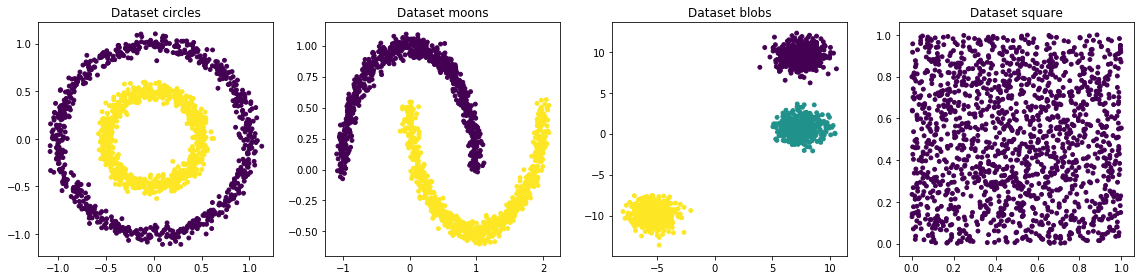

In [49]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4))

for data, axis in zip(datasets_tuple, ax.reshape(-1)):
    axis.scatter(data[1][:,0], data[1][:,1], c=data[2], s=15)
    axis.set_title('Dataset {}'.format(data[0]))
plt.tight_layout()

### 2 a. *k-means*

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> aplica la regla del colze per decidir el valor de $k$ en cada un dels datasets.
</div>

Distortion: 0.7516125920100082
Distortion: 0.5685234093869712
Distortion: 0.450598422377474
Distortion: 0.38647352841616195
Distortion: 0.3497644426761943
Distortion: 0.32474543475707834
Distortion: 0.308301160274984
Distortion: 0.2841274081232747
Distortion: 0.2575159604920764
Distortion: 0.23414394421754037
Distortion: 0.21310143323223968
Distortion: 0.19524228055272366
Distortion: 0.1817793181669234
Distortion: 0.17087017889707032
Distortion: 0.15948838500709062
Distortion: 0.1508446993342171
Distortion: 0.142569898737719
Distortion: 0.13594906569663945
Distortion: 0.13014809869102292


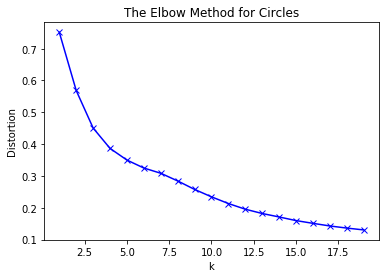

In [61]:
distortions = []
K = range(1,20)
# Seleccio de les dades de circle
X = data_circles[1]
for k in K:
    kmeanModel = cluster.KMeans(n_clusters=k, n_init=10, max_iter=300, random_state=0)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    print('Distortion: {}'.format(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0]))

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method for Circles')
plt.show()    

ANP: observem en el gràfic que en k=6 tenim un punt candidat, tot i que per k=7 torna a decreixer d'una forma més pronunciada. Podríem escollir k=10. Aquest valor, tal i com sabem, també dependrà del problema concret que estem tractant i de la opinió del client al respecte.

Distortion: 0.9247796054192682
Distortion: 0.6037132186785032
Distortion: 0.4864515710872705
Distortion: 0.3884133426117686
Distortion: 0.32512279799411237
Distortion: 0.2671979921844155
Distortion: 0.23550819594835581
Distortion: 0.205648741093308
Distortion: 0.18533242615164594
Distortion: 0.16690115892203106
Distortion: 0.15434344402037062
Distortion: 0.14297743588023118
Distortion: 0.1335767440979062
Distortion: 0.12509303610620673
Distortion: 0.1169415115614183
Distortion: 0.10942677117837174
Distortion: 0.10533883644196368
Distortion: 0.10080600851676377
Distortion: 0.09725504657128045


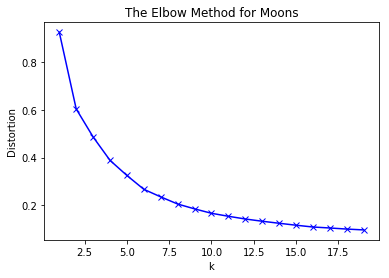

In [62]:
distortions = []
K = range(1,20)
# Seleccio de les dades de moon
X = data_moons[1]
for k in K:
    kmeanModel = cluster.KMeans(n_clusters=k, n_init=10, max_iter=300, random_state=0)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    print('Distortion: {}'.format(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0]))

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method for Moons')
plt.show()

ANP: observem que a partir de k=6 la linia decreix més suaument. Per tant k=6 o k=7 seria un bon valor per k.

Distortion: 9.264474419995521
Distortion: 3.4051915627539837
Distortion: 1.2481587173664936
Distortion: 1.1636184178875335
Distortion: 1.080429273215141
Distortion: 1.0061644192220855
Distortion: 0.9477077202153091
Distortion: 0.8840997490364355
Distortion: 0.8275728007471169
Distortion: 0.793309639714564


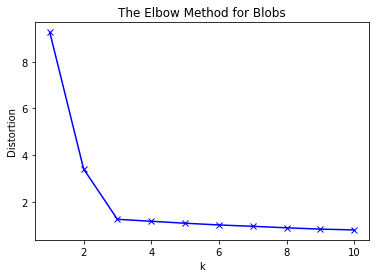

In [59]:
distortions = []
K = range(1,11)
# Seleccio de les dades de blobs
X = data_blobs[1]
for k in K:
    kmeanModel = cluster.KMeans(n_clusters=k, n_init=10, max_iter=300, random_state=0)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    print('Distortion: {}'.format(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0]))

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method for Blobs')
plt.show()

ANP: en aquest cas observem que clarament el valor idoni de k=3.

Distortion: 0.37549452007882556
Distortion: 0.29290472321068123
Distortion: 0.2324634119286818
Distortion: 0.19224881049316989
Distortion: 0.17342486138398094
Distortion: 0.15882501828307588
Distortion: 0.14652783041806647
Distortion: 0.13580790824406544
Distortion: 0.12717064793564042
Distortion: 0.12104666524880427


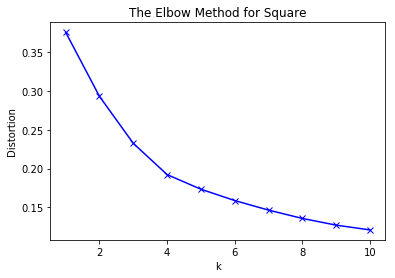

In [60]:
distortions = []
K = range(1,11)
# Seleccio de les dades de square
X = data_square[1]
for k in K:
    kmeanModel = cluster.KMeans(n_clusters=k, n_init=10, max_iter=300, random_state=0)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    print('Distortion: {}'.format(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0]))

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method for Square')
plt.show()

ANP: veient la gràfica podem observar que el millor valor seria per k=4

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> aplica <i>k-means</i> amb el valor de $k$ escollit en cada dataset.
<br>
Visualitza el resultat en un <i>scatter plot</i> representant cada clúster amb un color diferent.
</div>

IndexError: too many indices for array

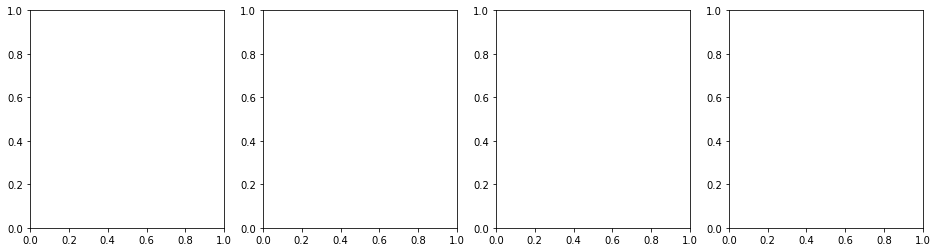

In [63]:
# Seleccio de les dades
X_circles = data_circles[1]
kmeanModel = cluster.KMeans(n_clusters=10, n_init=10, max_iter=300, random_state=0)
kmeanModel.fit(X_circles)

X_moons = data_moons[1]
kmeanModel = cluster.KMeans(n_clusters=7, n_init=10, max_iter=300, random_state=0)
kmeanModel.fit(X_moons)

X_blobs = data_blobs[1]
kmeanModel = cluster.KMeans(n_clusters=3, n_init=10, max_iter=300, random_state=0)
kmeanModel.fit(X_blobs)

X_square = data_square[1]
kmeanModel = cluster.KMeans(n_clusters=4, n_init=10, max_iter=300, random_state=0)
kmeanModel.fit(X_square)

# Guardem tots els datasets en una tupla.
datasets_tuple = (X_circles, X_moons, X_blobs, X_square)

fig, ax = plt.subplots(1, 4, figsize=(16, 4))

for data, axis in zip(datasets_tuple, ax.reshape(-1)):
    axis.scatter(data[1][:,0], data[1][:,1], c=data[2], s=15)
    axis.set_title('Dataset {}'.format(data[0]))
plt.tight_layout()


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi:</strong> Què ha passat? Explica els motius pels quals creus que s'ha produït aquest resultat.  
</div>

### 2 b. Agrupament Jeràrquic Aglomeratiu

En aquest apartat es demana visualitzar mitjançant un [dendrograma](https://en.wikipedia.org/wiki/Dendrogram) la construcció progressiva dels grups mitjançant un algoritme jeràrquic aglomeratiu (estratègia *bottom-up*). Amb això es pretén trobar un mètode gràfic per determinar el nombre de clústers en cada escenari.

Com mètrica s'emprarà la distància euclidiana, però com a [criteri d'enllaç o *linkage*](https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria) es demana provar diferents mètodes per a posteriorment comentar les seves resultats. Per a la implementació es poden utilitzar els mòduls dendogram i linkage de SciPy.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> prova diferents criteris d'enllaç amb el mètode jeràrquic aglomeratiu per seleccionar el criteri d'enllaç que permeti identificar els clústers subjacents a través del seu dendrograma.
</div>

<Figure size 432x288 with 0 Axes>

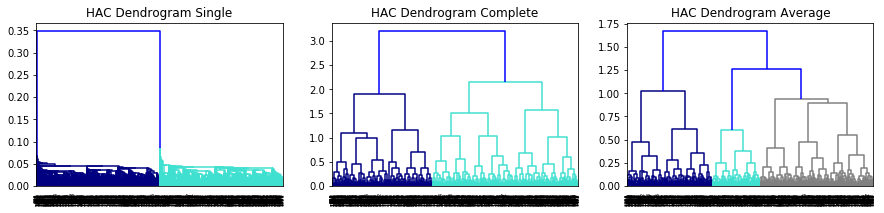

In [65]:
hac.set_link_color_palette(['navy', 'turquoise', 'grey', 'coral'])

plt.clf()
fig, axes = plt.subplots(1, 3, figsize=(15, 3))
# Perform hierarchical/agglomerative clustering
Z_s = hac.linkage(X, method='single', metric='euclidean')
Z_c = hac.linkage(X, method='complete', metric='euclidean')
Z_a = hac.linkage(X, method='average', metric='euclidean')
#plt.subplot(1, 1, 1)
axes[0].set_title('HAC Dendrogram Single')
axes[1].set_title('HAC Dendrogram Complete')
axes[2].set_title('HAC Dendrogram Average')
dn_s = hac.dendrogram(Z_s, ax=axes[0])
dn_c = hac.dendrogram(Z_c, ax=axes[1])
dn_a = hac.dendrogram(Z_a, ax=axes[2])
Hclustering = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='complete')
Hclustering.fit(X)
sm.accuracy_score(y, Hclustering.labels_)
#plt.subplot(1, 2, 1)
#plt.title('Hierarchical Clust. Dendrogram Complete')
plt.show()
#plt.subplot(1, 3, 3)
#plt.title('Hierarchical Clust. Dendrogram Average')
#dn3 = hierarchy.dendrogram(Z_a)



<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi:</strong> Quin criteri d'enllaç es comporta millor per als diferents escenaris? Per què?
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> després de seleccionar el criteri d'enllaç i els llindars (eix d'ordenades del dendrograma) en el pas anterior es demana visualitzar, per a cada dataset, 1 <i>scatter plot</i> on cada clúster quedi representat un color diferent. 
</div>

## 3. Reducció de dimensionalitat: PCA i t-SNE (3 punts)

En plantejar un problema de classificació amb un dataset de més de tres atributs (dimensions), no es pot fer una visualització clàssica del dataset per entendre les dades. Per això, un dels usos dels mètodes de reducció de dimensionalitat és transformar les dades de més de 4 dimensions a 3 o menys per poder visualitzar-los.

### 3 a. PCA

El [dataset Iris](https://es.wikipedia.org/wiki/Iris_flor_conjunto_de_datos) conté 4 atributs sobre tres tipus de flors.

In [9]:
iris = datasets.load_iris()
X = iris.data   # np.array amb shape (150, 4)
y = iris.target # np.array amb shape (150,)

En excedir les 3 dimensions necessitarem més d'una visualització per entendre les dades.

Per solucionar-ho, una alternativa és usar els [*pair plots*](http://seaborn.pydata.org/generated/seaborn.pairplot.html) que mostren parells de dimensions per intentar donar una visió global a partir d'un [DataFrame](https://pandas.pydata.org/pandas-docs/stable/dsintro.html):

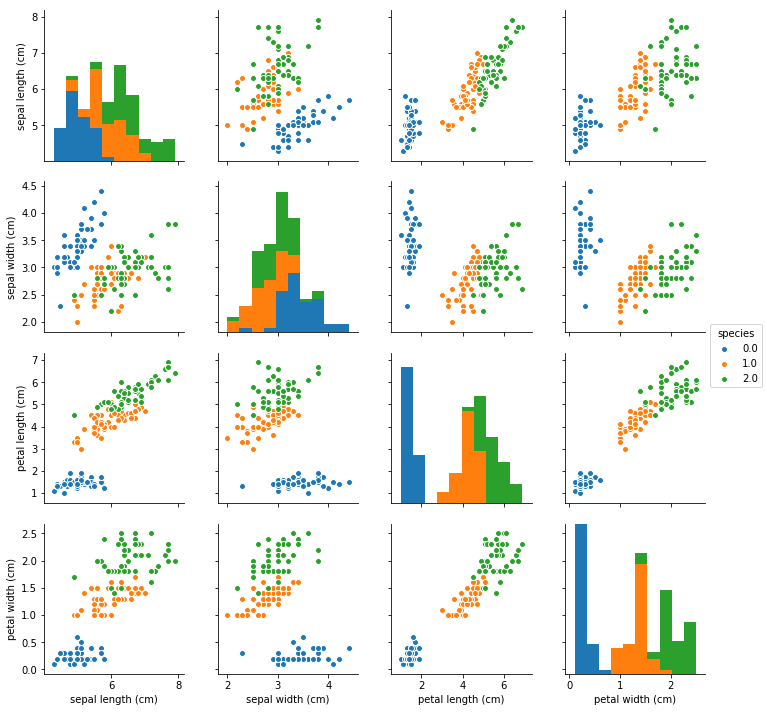

In [10]:
# DataFrame 
iris_df = pd.DataFrame(np.hstack([X, y.reshape(-1, 1)]), columns=iris.feature_names + ['species'])
sns.pairplot(iris_df, vars=iris.feature_names, hue="species")

Com a alternativa a les múltiples gràfiques que generen els *pair plots*, es planteja utilitzar una tècnica de reducció de dimensionalitat per passar de 4 dimensions a 2. Cal notar que gràfiques com *longitud de pètal* vs *amplada de pètal* mostren certa separabilitat (els 3 tipus de flors estan aparentment separats).

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> realitzar una reducció de dimensionalitat amb PCA per passar de 4 dimensions a 2 i crear una visualització on el color dels punts depengui del tipus de flor a la qual pertany. Es pot utilitzar la implementació de PCA en scikit-learn que es va utilitzar en la PAC1.
</div>

Explained variance ratio (first two components): [0.72770452 0.23030523]


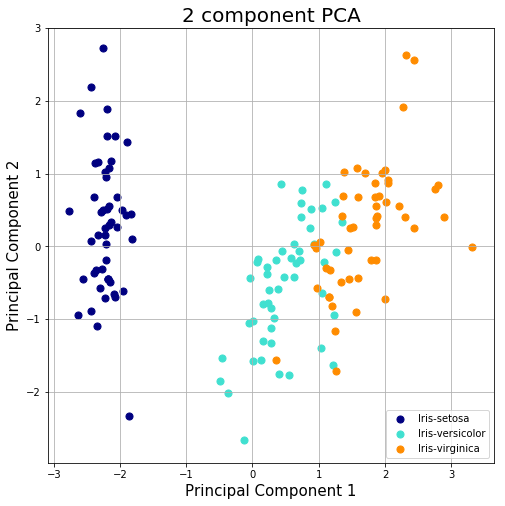

In [11]:
X_std = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)        #number of components to keep
principalComponents = pca.fit_transform(X_std)
principalDf = pd.DataFrame(data=principalComponents)

finalDf = pd.concat([principalDf, pd.DataFrame(data=y)], axis=1)
finalDf.columns = ['PC1','PC2','target']
fig = plt.figure(figsize = (8,8))

ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
target_names = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
targets = [0, 1, 2]
colors = ['navy', 'turquoise', 'darkorange']

for target, color in zip(targets, colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1'], finalDf.loc[indicesToKeep, 'PC2'], c=color, s=50)

ax.legend(target_names)
ax.grid()

# Percentage of variance explained for each components
print('Explained variance ratio (first two components): %s' % str(pca.explained_variance_ratio_))

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi:</strong> El resultat de la reducció de dimensionalitat manté la separabilitat? Era d'esperar? Per què?
</div>

### 3 b. t-SNE (t-distributed Stochastic Neighbor Embedding)

L'ús de tècniques de reducció de dimensionalitat és de gran utilitat quan aquesta és molt alta. Per exemple, el [dataset Digits](http://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html) conté 1797 imatges de nombres del 0 al 9, de 8 per 8 píxels. Si es pren cada píxel com una dimensió, això es tradueix en què cada mostra té 64 dimensions!

In [12]:
digits = datasets.load_digits()
X = digits.data   # np.array amb shape (1797, 64)
y = digits.target # np.array amb shape (1797,)
#print(digits['DESCR'])

Exemple dels 24 primers números de 8 per 8 píxels al costat de la seva etiqueta presents al dataset:

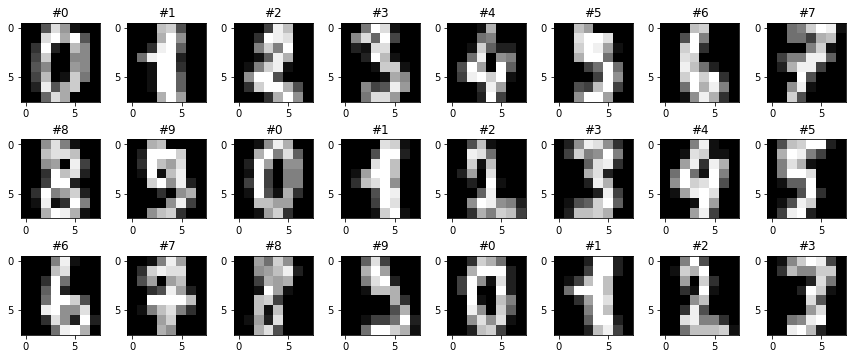

In [13]:
fig, ax = plt.subplots(3, 8, figsize=(12, 5))
for i, axis in zip(range(24), ax.reshape(-1)):
    axis.imshow(X[i,:].reshape(8, 8), cmap='gray')
    axis.set_title('#{}'.format(y[i]))
plt.tight_layout()

Amb un nombre tan elevat de dimensions perd sentit visualitzar el dataset amb un * pair plot * i apareixen altres perills com la [maldició de la dimensionalitat](https://es.wikipedia.org/wiki/Maldici%C3%B3n_de_la_dimensi%C3%B3n).
Per reduir la seva dimensió i així entendre l'estructura de les dades en alta dimensionalitat hi ha diferents alternatives amb resultats molt diferents.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> realitzar una reducció de dimensionalitat amb PCA per passar de 64 dimensions a 2 i crear una visualització on el color dels punts depengui del dígit que pertany.
</div>

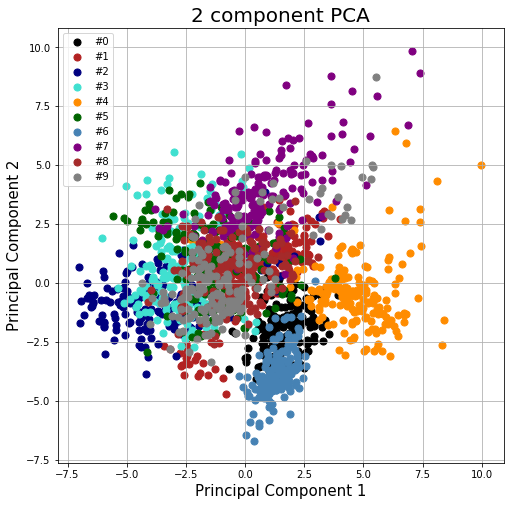

In [14]:
X_std = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)        #number of components to keep
principalComponents = pca.fit_transform(X_std)
principalDf = pd.DataFrame(data=principalComponents)

finalDf = pd.concat([principalDf, pd.DataFrame(data=y)], axis=1)
finalDf.columns = ['PC1','PC2','target']
fig = plt.figure(figsize = (8,8))

ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
target_names = ['#0','#1','#2','#3','#4','#5','#6','#7','#8','#9']
targets = list(set(y))
colors = ['black','firebrick','navy','turquoise','darkorange','darkgreen','steelblue','purple','brown','gray']

for target, color in zip(targets, colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1'], finalDf.loc[indicesToKeep, 'PC2'], c=color, s=50)

ax.legend(target_names)
ax.grid()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi:</strong> El resultat de la reducció de dimensionalitat manté la separabilitat? Era d'esperar? Per què?
</div>

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (1.0, 0.4980392156862745, 0.054901960784313725), (0.17254901960784313, 0.6274509803921569, 0.17254901960784313), (0.8392156862745098, 0.15294117647058825, 0.1568627450980392), (0.5803921568627451, 0.403921568627451, 0.7411764705882353), (0.5490196078431373, 0.33725490196078434, 0.29411764705882354), (0.8901960784313725, 0.4666666666666667, 0.7607843137254902), (0.4980392156862745, 0.4980392156862745, 0.4980392156862745), (0.7372549019607844, 0.7411764705882353, 0.13333333333333333), (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]


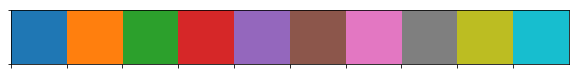

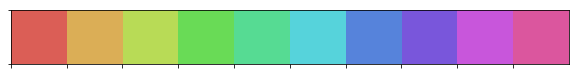

In [15]:
current_palette = sns.color_palette()
type(current_palette)
print(current_palette)
sns.palplot(current_palette)
palette = np.array(sns.color_palette("hls", 10))
sns.palplot(palette)

L'algoritme [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) desenvolupat per [van der Maaten y Hinton](https://lvdmaaten.github.io/tsne/) difereix de PCA en què no tracta de maximitzar la variància explicada. Intuïtivament, t-SNE tracta que el veïnatge d'un punt en baixa dimensionalitat sigui la mateixa que l'original. Partint d'una localització aleatòria de cada punt, corregeix la seva posició de forma iterativa tractant de minimitzar la distància als seus veïns originals fins a convergir.

Per a això, t-SNE disposa de diversos [paràmetres](https://distill.pub/2016/misread-tsne/) que poden modificar dràsticament el resultat. Pel que recomana conèixer el seu funcionament abans d'aplicar la tècnica.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> realitzar una reducció de dimensionalitat amb t-SNE per passar de 64 dimensions a 2 i crear una visualització on el color dels punts depengui del dígit que pertany. La llibreria scikit-learn conté un mòdul TSNE que permet realitzar aquest tipus de reducció de dimensionalitat.
</div>

In [ ]:
# Getting the most from t-SNE may mean analyzing multiple plots with different perplexities.
# The t-SNE algorithm doesn’t always produce similar output on successive runs
from sklearn.manifold import TSNE
# We'll hack a bit with the t-SNE code in sklearn 0.15.2.
#from sklearn.metrics.pairwise import pairwise_distances
#from sklearn.manifold.t_sne import (_joint_probabilities, _kl_divergence)
#import matplotlib.patheffects as PathEffects
#from sklearn.utils.extmath import _ravel
# Random state.
RS = 20170401

# We first reorder the data points according to the handwritten numbers.
X = np.vstack([digits.data[digits.target==i]
               for i in range(10)])
y = np.hstack([digits.target[digits.target==i]
               for i in range(10)])
digits_proj = TSNE(n_components=2, perplexity=30.0, metric='euclidean', n_iter=1000, method='barnes_hut', random_state=RS).fit_transform(X)
print(digits_proj.shape)

def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([PathEffects.Stroke(linewidth=5, foreground="w"), PathEffects.Normal()])
        txts.append(txt)
    return f, ax, sc, txts

scatter(digits_proj, y)


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi:</strong> El resultat de la reducció de dimensionalitat manté la separabilitat? Era d'esperar? Per què?
</div>

## 4. Aplicacions (2 punts)

### 4 a. Compressió de imatges

Les imatges en color es composen de píxels que tenen tres components (vermell, blau i verd), destinant 1 *byte* a cada canal. Per tant, podent representar $2 ^ 8 = 256$ vermells, verds i blaus, amb un total de $2^{8^{3}} = 2^{24} = 16777216$ colors representables en cada píxel.

Com més gran sigui el nombre de colors representables, més memòria serà necessària per a emmagatzemar la imatge.
Per tant, una estratègia per comprimir una imatge pot ser disminuir els colors representables en cada píxel, necessitant menys *bits* per guardar el valor d'un píxel. Aquest mètode no és reversible, és a dir, no es pot tornar a recuperar la imatge original a partir de la comprimida. Per tant, aquest tipus de compresión s'anomena [compressió amb pèrdua](https://es.wikipedia.org/wiki/Algoritmo_de_compresi%C3%B3n_con_p%C3%A9rdida).

Però, com seleccionem els "píxels semblants" a la imatge original i determinem el seu color a la imatge comprimida? Una opció és utilitzar *k-means* on **$k$ serà el nombre de colors representables**, els punts que pertanyen a cada clúster equivaldrien als "píxels semblants" i les coordenades dels **centroides actuaran com els colors finals** als quals s'aproximaran els "píxels semblants".

Com a resultat del clustering, s'obté una paleta de colors reduïda (coordenades dels centroides) on cada píxel de la imatge farà referència a un d'aquests colors (clúster al qual pertany). L'ús de paletes de colors o [colors indexats](https://en.wikipedia.org/wiki/Indexed_color) és un recurs utilitzat per diferents formats de imatges, com *PNG*, *GIF* o *TIFF*.

c:\users\anperez\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\datasets\base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]
c:\users\anperez\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\datasets\base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]


(150, 225, 3)
(33750, 3)
Imatge amb 33750 píxels (101250 bytes)


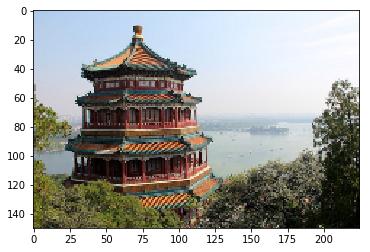

In [36]:
photo = transform.resize(datasets.load_sample_image("china.jpg"), (150, 225), mode='edge')
plt.imshow(photo)
print(photo.shape)
X = photo.reshape(-1, 3) # np.array amb shape (33750, 3)
print(X.shape)
print('Imatge amb {} píxels ({} bytes)'.format(X.shape[0], X.shape[0] * 3))

Per facilitar la tasca, la imatge anterior està guardada en un *array* amb tantes files com píxels i columnes com canals (vermell, verd i blau). De manera que cada "mostra" equival al valor d'un píxel.

Es pot tornar a recompondre la imatge original amb:
```
plt.imshow(X.reshape(photo.shape))
```
Podem veure cada píxel com un punt en un sistema de coordenades de 3 dimensions on una és la seva quantitat de vermell, una altra la seva quantitat de verd i finalment la seva quantitat de blau. Pel que podem fer una visualització en 3 dimensions dels píxels sobre la qual es provarà l'algoritme de clustering:

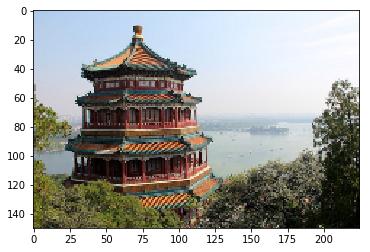

In [24]:
plt.imshow(X.reshape(photo.shape))

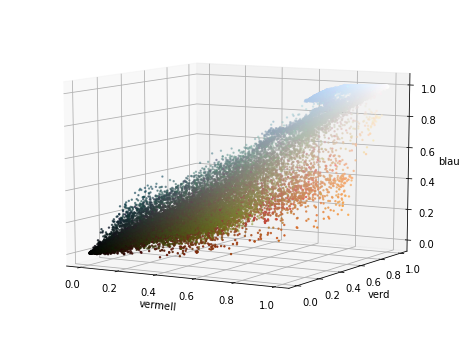

In [35]:
def plot_pixels_3d(data: "np.array[float]", elev: int = None, azim: int = None) -> NoReturn:
    """Visualitza píxels en un scatter plot 3d (una por canal) amb el seu color corresponnent.
    
    Args:
        data: np.array (punts, 3)
        elev: int
            angle d'elevació en el pla z.
        azim: int
            angle acimut en el pla x, y.
    """
    assert data.shape[1] == 3, 'Cal un array bidimensional amb 3 columnes: (vermell, verd i blau)'
    #print(data.size)
    ax = plt.figure(figsize=(8, 6)).add_subplot(111, projection='3d')
    ax.scatter(data[:,0], data[:,1], data[:,2], s=2, c=data)
    ax.set_xlabel('vermell')
    ax.set_ylabel('verd')
    ax.set_zlabel('blau')
    ax.view_init(elev, azim)
    plt.show()

plot_pixels_3d(X, 10)

A la visualització anterior s'ha representat cada píxel amb el seu color, on les seves coordenades en els 3 colors oscil·len entre 0 (no té aquesta component) i 1. Podem comprovar com els píxels en coordenades (1, 1, 1) (a dalt a la dreta) són píxels blancs i els situats en (0, 0, 0) són píxels negres. També s'observen 3 núvols de píxels: un blau, on hi ha els píxels del cel i aigua, un altra verd que es correspon amb els píxels de la vegetació i una rogenca per a la Pagoda.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> representar la imatge amb 256, 128, 64, 32, 16, 8, 4 i 2 colors i indicar els bytes que ocuparia cadascuna de les opcions.
</div>

In [37]:
#2 colors
X_2 = photo.reshape(-1, 2) # np.array amb shape (50625, 2)
print(X_2.shape[0])
print(X_2.shape[1])
print('Imatge amb {} píxels ({} bytes)'.format(X_2.shape[0], X_2.shape[0] * 2))
#plot_pixels_3d(X_2, 10)

50625
2
Imatge amb 50625 píxels (101250 bytes)


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Anàlisi:</strong> Descriu el comportament de <i>k-means</i> sobre les imatges. ¿Un altre algoritme produiria un resultat diferent? Quines diferències i per què?
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>[OPCIONAL] Implementació:</strong> realitza la compressió d'imatges amb un altre algorisme de clustering. 
</div>

### 4 b. Segmentació d'imatges de satèl·lit

Avui dia els mapes de carreteres, geològics, agrícoles... es confeccionen amb imatges satèl·lits. Per a això cal interpretar aquestes imatges buscant-hi els elements d'interès. Donat el volum actual d'imatges que generen els satèl·lits, fer la segmentació de forma manual no és una opció i per això hi ha tants esforços en la seva automatització.

Assumint que l'espai de píxels té certa estructura i que els diferents elements a cercar són grups en ella, és raonable pensar que una estratègia de clustering (entre moltes altres) pot trobar aquests grups en aquesta estructura, permetent automatitzar la segmentació d'imatges.

Partim d'una imatge amb diversos tipus de vegetació i camins:

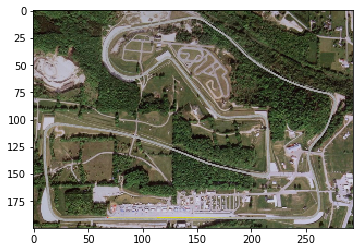

In [16]:
photo = transform.resize(
    io.imread('http://www.trackcreation.net/devdiary/images/road_america_base.jpg'),
    (200, 294), mode='edge')
plt.imshow(photo)
X = photo.reshape(-1, 3)

Igual que en l'apartat anterior, s'ha donat un format de *array* a la imatge amb tantes files com píxels i 3 columnes (una per canal).

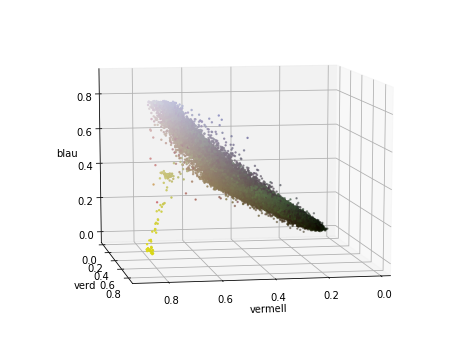

In [17]:
plot_pixels_3d(X, 10, 80)

Visualitzant en 3 dimensions els píxels de la imatge veiem que en aquest cas no estan tan diferenciats els grups. Però sí que els píxels més clars pertanyen a la zona de camins i els més foscos a l'àrea de vegetació.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació:</strong> aplica una tècnica de clustering per separar els camins de la vegetació i visualitza tant la imatge original com la resultant després d'aplicar la segmentació per comparar el resultat.
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementació i anàlisi:</strong> torna a aplicar-ho buscant 3 clústers. Quina regió representa cada un d'ells?
</div>